In [ ]:
!pip install CoolProp
!pip install pyswarms

In [ ]:
import CoolProp.CoolProp as CP
import numpy as np
import pyswarms as ps

# Valores fixados
refri1 = 'R123'  # Ciclo superior
refri2 = 'R600a'  # Ciclo inferior
carga_termica = 2000  # Carga térmica em Watts
delta_T = 5  # Diferença de temperatura no trocador cascata
T_cond = 50 + 273.15  # Temperatura de condensação
efi = 0.7 # Eficiência Isentrópica do Compressor
T_evap = -25 + 273.15 # Temperatura de evaporação
superaquecimento = 5 # O quanto que o trocador de calor interno aumenta a temperatura

# Função para calcular COP, UA, e outras variáveis
def calcular_COP_e_UA(P_3):
    # Estado 1 (saída do evaporador)
    Temperatura_1 = T_evap
    h_1 = CP.PropsSI('H', 'T', Temperatura_1, 'Q', 1, refri2)
    P_1 = CP.PropsSI('P', 'T', Temperatura_1, 'Q', 1, refri2)

    # Estado 2 (entrada compressor inferior 1)
    P_2 = P_1
    Temperatura_2 = Temperatura_1 + superaquecimento
    h_2 = CP.PropsSI('H', 'P', P_2, 'T', Temperatura_2, refri2)
    s_2 = CP.PropsSI('S', 'P', P_2, 'T', Temperatura_2, refri2)

    # Estado 3 (saída do compressor 1)
    h_3s = CP.PropsSI('H', 'P', P_3, 'S', s_2, refri2)
    h_3 = ((h_3s - h_2) / efi) + h_2
    Temperatura_3 = CP.PropsSI('T', 'P', P_3, 'H', h_3, refri2)
    s_3 = CP.PropsSI('S', 'P', P_3, 'H', h_3, refri2)

    # Estado 4 (saída trocador cascata)
    h_4 = CP.PropsSI('H', 'P', P_3, 'Q', 0, refri2)
    Temperatura_4 = CP.PropsSI('T', 'P', P_3, 'Q', 0, refri2)
    s_4 = CP.PropsSI('S', 'P', P_3, 'Q', 0, refri2)

    # Estado 5 (saída do trocador intermediário)
    h_5 = h_1 + h_4 - h_2

    # Estado 6 (saída da válvula)
    h_6 = h_5

    # Estado 7 (entrada do compressor 2)
    Temperatura_7 = Temperatura_4 - delta_T
    h_7 = CP.PropsSI('H', 'T', Temperatura_7, 'Q', 1, refri1)
    s_7 = CP.PropsSI('S', 'T', Temperatura_7, 'Q', 1, refri1)
    P_7 = CP.PropsSI('P', 'T', Temperatura_7, 'Q', 1, refri1)

    # Estado 9 (saída do condensador)
    P_9 = CP.PropsSI('P', 'T', T_cond, 'Q', 0, refri1)
    h_9 = CP.PropsSI('H', 'T', T_cond, 'Q', 0, refri1)

    # Estado 8 (saída do compressor 2)
    h_8s = CP.PropsSI('H', 'P', P_9, 'S', s_7, refri1)
    h_8 = ((h_8s - h_7) / efi) + h_7

    # Estado 10 (saída da válvula)
    h_10 = h_9
    Temperatura_10 = CP.PropsSI('T', 'P', P_7, 'H', h_10, refri1)
    s_10 = CP.PropsSI('S', 'P', P_7, 'H', h_10, refri1)

    # Cálculo das vazões mássicas
    m1 = carga_termica / (h_1 - h_6)
    m2 = m1 * ((h_4 - h_3) / (h_10 - h_7))

    # Trabalhos e COP
    w1 = m1 * (h_3 - h_2)
    w2 = m2 * (h_8 - h_7)
    COP = carga_termica / (w1 + w2)

    # Cálculo da diferença de temperatura média logarítmica (LMTD)
    delta_T_m = (((Temperatura_3 - Temperatura_10) - (Temperatura_4 - Temperatura_7)) /
                 np.log((Temperatura_3 - Temperatura_10) / (Temperatura_4 - Temperatura_7)))

    # Cálculo de Q
    Q = m2 * (h_7 - h_10)  # Calor trocado no ciclo superior

    # Cálculo de UA
    UA = Q / delta_T_m

    return COP, UA

# Função objetivo para o PSO
def funcao_objetivo(x):
    P_3 = x[:, 0]
    COP_valores = np.array([-calcular_COP_e_UA(P_3[i])[0] for i in range(len(P_3))])
    return COP_valores

# Restrições
P3_min, P3_max = 58427, 750000
limites = (np.array([P3_min]), np.array([P3_max]))

# Configuração do PSO
opcoes = {'c1': 1.5, 'c2': 1.5, 'w': 0.5}
optimizer = ps.single.GlobalBestPSO(n_particles=15, dimensions=1, options=opcoes, bounds=limites)

# Execução do PSO
melhor_custo, melhor_posicao = optimizer.optimize(funcao_objetivo, iters=40)

# Resultados
P3_otimo = melhor_posicao[0]
COP_otimizado, UA_otimizado = calcular_COP_e_UA(P3_otimo)

print(f"Resultados ótimos:")
print(f"P3 = {P3_otimo / 1000:.2f} kPa")
print(f"COP máximo = {COP_otimizado:.4f}")
print(f"UA correspondente = {UA_otimizado:.4f} W/K")

2025-02-17 15:44:07,912 - pyswarms.single.global_best - INFO - Optimize for 40 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|40/40, best_cost=-1.76
2025-02-17 15:44:10,833 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.7605882366121983, best pos: [240486.15224017]


Resultados ótimos:
P3 = 240.49 kPa
COP máximo = 1.7606
UA correspondente = 209.1594 W/K


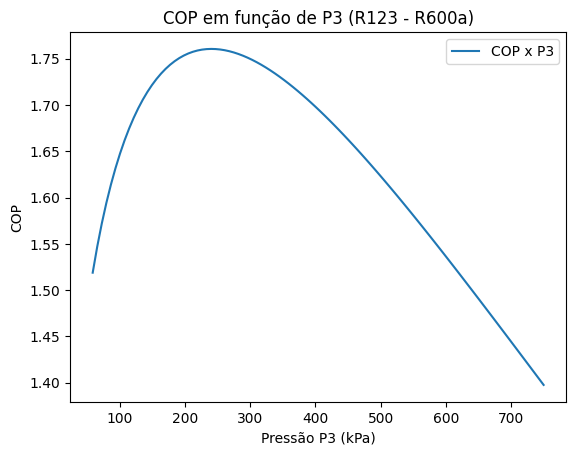

In [ ]:
import CoolProp.CoolProp as CP
import numpy as np
from matplotlib.pyplot import plot, xlabel, ylabel, title, show, legend, grid

# Valores fixados
refri1 = 'R123'  # Ciclo superior
refri2 = 'R600a'  # Ciclo inferiorr
carga_termica = 2000  # Carga térmica em Watts
delta_T = 5  # Diferença de temperatura no trocador cascata
T_cond = 50 + 273.15  # Temperatura de condensação
efi = 0.7 # Eficiência Isentrópica do Compressor
T_evap = -25 + 273.15 # Temperatura de evaporação
superaquecimento = 5 # O quanto que o trocador de calor interno aumenta a temperatura

valores_de_P3 = np.linspace(58427, 750000, 100)
valores_COP = []
pressoes_p3 = []

# Função para calcular COP, UA, e outras variáveis
for P_3 in valores_de_P3:
    # Estado 1 (saída do evaporador)
    Temperatura_1 = T_evap
    h_1 = CP.PropsSI('H', 'T', Temperatura_1, 'Q', 1, refri2)
    P_1 = CP.PropsSI('P', 'T', Temperatura_1, 'Q', 1, refri2)

    # Estado 2 (entrada compressor inferior 1)
    P_2 = P_1
    Temperatura_2 = Temperatura_1 + superaquecimento
    h_2 = CP.PropsSI('H', 'P', P_2, 'T', Temperatura_2, refri2)
    s_2 = CP.PropsSI('S', 'P', P_2, 'T', Temperatura_2, refri2)

    # Estado 3 (saída do compressor 1)
    h_3s = CP.PropsSI('H', 'P', P_3, 'S', s_2, refri2)
    h_3 = ((h_3s - h_2) / efi) + h_2
    Temperatura_3 = CP.PropsSI('T', 'P', P_3, 'H', h_3, refri2)
    s_3 = CP.PropsSI('S', 'P', P_3, 'H', h_3, refri2)

    # Estado 4 (saída trocador cascata)
    h_4 = CP.PropsSI('H', 'P', P_3, 'Q', 0, refri2)
    Temperatura_4 = CP.PropsSI('T', 'P', P_3, 'Q', 0, refri2)
    s_4 = CP.PropsSI('S', 'P', P_3, 'Q', 0, refri2)

    # Estado 5 (saída do trocador intermediário)
    h_5 = h_1 + h_4 - h_2

    # Estado 6 (saída da válvula)
    h_6 = h_5

    # Estado 7 (entrada do compressor 2)
    Temperatura_7 = Temperatura_4 - delta_T
    h_7 = CP.PropsSI('H', 'T', Temperatura_7, 'Q', 1, refri1)
    s_7 = CP.PropsSI('S', 'T', Temperatura_7, 'Q', 1, refri1)
    P_7 = CP.PropsSI('P', 'T', Temperatura_7, 'Q', 1, refri1)

    # Estado 9 (saída do condensador)
    P_9 = CP.PropsSI('P', 'T', T_cond, 'Q', 0, refri1)
    h_9 = CP.PropsSI('H', 'T', T_cond, 'Q', 0, refri1)

    # Estado 8 (saída do compressor 2)
    h_8s = CP.PropsSI('H', 'P', P_9, 'S', s_7, refri1)
    h_8 = ((h_8s - h_7) / efi) + h_7

    # Estado 10 (saída da válvula)
    h_10 = h_9
    Temperatura_10 = CP.PropsSI('T', 'P', P_7, 'H', h_10, refri1)
    s_10 = CP.PropsSI('S', 'P', P_7, 'H', h_10, refri1)

    # Cálculo das vazões mássicas
    m1 = carga_termica / (h_1 - h_6)
    m2 = m1 * ((h_4 - h_3) / (h_10 - h_7))

    # Trabalhos e COP
    w1 = m1 * (h_3 - h_2)
    w2 = m2 * (h_8 - h_7)
    COP = carga_termica / (w1 + w2)

    # Cálculo da diferença de temperatura média logarítmica (LMTD)
    delta_T_m = (((Temperatura_3 - Temperatura_10) - (Temperatura_4 - Temperatura_7)) /
                 np.log((Temperatura_3 - Temperatura_10) / (Temperatura_4 - Temperatura_7)))

    # Cálculo de Q
    Q = m2 * (h_7 - h_10)  # Calor trocado no ciclo superior

    # Cálculo de UA
    UA = Q / delta_T_m

    valores_COP.append(COP)
    pressoes_p3.append(P_3 / 1e3)

# Plotar o gráfico COP x Psep
plot(pressoes_p3, valores_COP, label='COP x P3')

# Configurações do gráfico
xlabel('Pressão P3 (kPa)')
ylabel('COP')
title('COP em função de P3 (R123 - R600a)')
legend()
grid(False)
show()

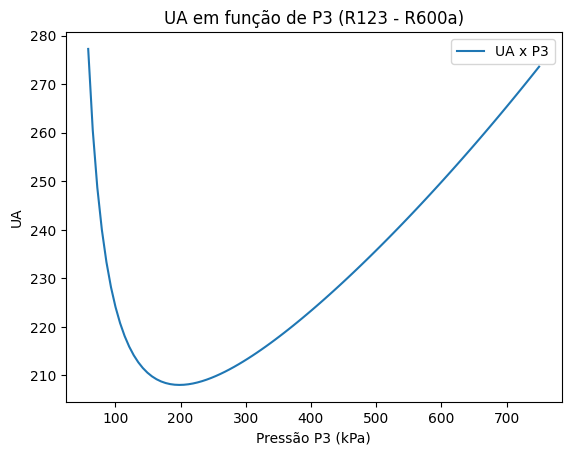

In [ ]:
import CoolProp.CoolProp as CP
import numpy as np
from matplotlib.pyplot import plot, xlabel, ylabel, title, show, legend, grid

# Valores fixados
refri1 = 'R123'  # Ciclo superior
refri2 = 'R600a'  # Ciclo inferior
carga_termica = 2000  # Carga térmica em Watts
delta_T = 5  # Diferença de temperatura no trocador cascata
T_cond = 50 + 273.15  # Temperatura de condensação
efi = 0.7 # Eficiência Isentrópica do Compressor
T_evap = -25 + 273.15 # Temperatura de evaporação
superaquecimento = 5 # O quanto que o trocador de calor interno aumenta a temperatura

valores_de_P3 = np.linspace(58427, 750000, 100)
valores_UA = []
pressoes_p3 = []

# Função para calcular COP, UA, e outras variáveis
for P_3 in valores_de_P3:
    # Estado 1 (saída do evaporador)
    Temperatura_1 = T_evap
    h_1 = CP.PropsSI('H', 'T', Temperatura_1, 'Q', 1, refri2)
    P_1 = CP.PropsSI('P', 'T', Temperatura_1, 'Q', 1, refri2)

    # Estado 2 (entrada compressor inferior 1)
    P_2 = P_1
    Temperatura_2 = Temperatura_1 + superaquecimento
    h_2 = CP.PropsSI('H', 'P', P_2, 'T', Temperatura_2, refri2)
    s_2 = CP.PropsSI('S', 'P', P_2, 'T', Temperatura_2, refri2)

    # Estado 3 (saída do compressor 1)
    h_3s = CP.PropsSI('H', 'P', P_3, 'S', s_2, refri2)
    h_3 = ((h_3s - h_2) / efi) + h_2
    Temperatura_3 = CP.PropsSI('T', 'P', P_3, 'H', h_3, refri2)
    s_3 = CP.PropsSI('S', 'P', P_3, 'H', h_3, refri2)

    # Estado 4 (saída trocador cascata)
    h_4 = CP.PropsSI('H', 'P', P_3, 'Q', 0, refri2)
    Temperatura_4 = CP.PropsSI('T', 'P', P_3, 'Q', 0, refri2)
    s_4 = CP.PropsSI('S', 'P', P_3, 'Q', 0, refri2)

    # Estado 5 (saída do trocador intermediário)
    h_5 = h_1 + h_4 - h_2

    # Estado 6 (saída da válvula)
    h_6 = h_5

    # Estado 7 (entrada do compressor 2)
    Temperatura_7 = Temperatura_4 - delta_T
    h_7 = CP.PropsSI('H', 'T', Temperatura_7, 'Q', 1, refri1)
    s_7 = CP.PropsSI('S', 'T', Temperatura_7, 'Q', 1, refri1)
    P_7 = CP.PropsSI('P', 'T', Temperatura_7, 'Q', 1, refri1)

    # Estado 9 (saída do condensador)
    P_9 = CP.PropsSI('P', 'T', T_cond, 'Q', 0, refri1)
    h_9 = CP.PropsSI('H', 'T', T_cond, 'Q', 0, refri1)

    # Estado 8 (saída do compressor 2)
    h_8s = CP.PropsSI('H', 'P', P_9, 'S', s_7, refri1)
    h_8 = ((h_8s - h_7) / efi) + h_7

    # Estado 10 (saída da válvula)
    h_10 = h_9
    Temperatura_10 = CP.PropsSI('T', 'P', P_7, 'H', h_10, refri1)
    s_10 = CP.PropsSI('S', 'P', P_7, 'H', h_10, refri1)

    # Cálculo das vazões mássicas
    m1 = carga_termica / (h_1 - h_6)
    m2 = m1 * ((h_4 - h_3) / (h_10 - h_7))

    # Trabalhos e COP
    w1 = m1 * (h_3 - h_2)
    w2 = m2 * (h_8 - h_7)
    COP = carga_termica / (w1 + w2)

    # Cálculo da diferença de temperatura média logarítmica (LMTD)
    delta_T_m = (((Temperatura_3 - Temperatura_10) - (Temperatura_4 - Temperatura_7)) /
                 np.log((Temperatura_3 - Temperatura_10) / (Temperatura_4 - Temperatura_7)))

    # Cálculo de Q
    Q = m2 * (h_7 - h_10)  # Calor trocado no ciclo superior

    # Cálculo de UA
    UA = Q / delta_T_m

    valores_UA.append(UA)
    pressoes_p3.append(P_3 / 1e3)

# Plotar o gráfico COP x Psep
plot(pressoes_p3, valores_UA, label='UA x P3')

# Configurações do gráfico
xlabel('Pressão P3 (kPa)')
ylabel('UA')
title('UA em função de P3 (R123 - R600a)')
legend()
grid(False)
show()

In [ ]:
import CoolProp.CoolProp as CP
import numpy as np
from matplotlib.pyplot import plot, xlabel, ylabel, title, show, legend, grid

# Valores fixados
refri1 = 'R123'  # Ciclo superior
refri2 = 'R600a'  # Ciclo inferior
carga_termica = 2000  # Carga térmica em Watts
delta_T = 5  # Diferença de temperatura no trocador cascata
T_cond = 50 + 273.15  # Temperatura de condensação
efi = 0.7 # Eficiência Isentrópica do Compressor
T_evap = -25 + 273.15 # Temperatura de evaporação
superaquecimento = 5 # O quanto que o trocador de calor interno aumenta a temperatura

P_3 = 709890

# Estado 0
t0 = 30 + 273.15  # Temperatura ambiente (K)
p0 = 101325  # Pressão ambiente (Pa)
h0_2 = CP.PropsSI('H', 'T', t0, 'P', p0, refri2)
s0_2 = CP.PropsSI('S', 'T', t0, 'P', p0, refri2)
h0_1 = CP.PropsSI('H', 'T', t0, 'P', p0, refri1)
s0_1 = CP.PropsSI('S', 'T', t0, 'P', p0, refri1)
tl = -16 + 273.15

# Estado 1 (saída do evaporador)
Temperatura_1 = T_evap
h_1 = CP.PropsSI('H', 'T', Temperatura_1, 'Q', 1, refri2)
P_1 = CP.PropsSI('P', 'T', Temperatura_1, 'Q', 1, refri2)
s_1 = CP.PropsSI('S', 'T', Temperatura_1, 'Q', 1, refri2)
af1 = (h_1 - h0_2) - (t0 * (s_1 - s0_2))

# Estado 2 (entrada compressor inferior 1)
P_2 = P_1
Temperatura_2 = Temperatura_1 + superaquecimento
h_2 = CP.PropsSI('H', 'P', P_2, 'T', Temperatura_2, refri2)
s_2 = CP.PropsSI('S', 'P', P_2, 'T', Temperatura_2, refri2)
af2 = (h_2 - h0_2) - (t0 * (s_2 - s0_2))

# Estado 3 (saída do compressor 1)
h_3s = CP.PropsSI('H', 'P', P_3, 'S', s_2, refri2)
h_3 = ((h_3s - h_2) / efi) + h_2
Temperatura_3 = CP.PropsSI('T', 'P', P_3, 'H', h_3, refri2)
s_3 = CP.PropsSI('S', 'P', P_3, 'H', h_3, refri2)
af3 = (h_3 - h0_2) - (t0 * (s_3 - s0_2))

# Estado 4 (saída trocador cascata)
h_4 = CP.PropsSI('H', 'P', P_3, 'Q', 0, refri2)
Temperatura_4 = CP.PropsSI('T', 'P', P_3, 'Q', 0, refri2)
s_4 = CP.PropsSI('S', 'P', P_3, 'Q', 0, refri2)
af4 = (h_4 - h0_2) - (t0 * (s_4 - s0_2))

# Estado 5 (saída do trocador intermediário)
h_5 = h_1 + h_4 - h_2
s_5 = CP.PropsSI('S', 'P', P_3, 'H', h_5, refri2)
af5 = (h_5 - h0_2) - (t0 * (s_5 - s0_2))

# Estado 6 (saída da válvula)
h_6 = h_5
P_6 = P_1
s_6 = CP.PropsSI('S', 'P', P_6, 'H', h_6, refri2)
af6 = (h_6 - h0_2) - (t0 * (s_6 - s0_2))

# Estado 7 (entrada do compressor 2)
Temperatura_7 = Temperatura_4 - delta_T
h_7 = CP.PropsSI('H', 'T', Temperatura_7, 'Q', 1, refri1)
s_7 = CP.PropsSI('S', 'T', Temperatura_7, 'Q', 1, refri1)
P_7 = CP.PropsSI('P', 'T', Temperatura_7, 'Q', 1, refri1)
af7 = (h_7 - h0_1) - (t0 * (s_7 - s0_1))

# Estado 9 (saída do condensador)
P_9 = CP.PropsSI('P', 'T', T_cond, 'Q', 0, refri1)
h_9 = CP.PropsSI('H', 'T', T_cond, 'Q', 0, refri1)
s_9 = CP.PropsSI('S', 'T', T_cond, 'Q', 0, refri1)
af9 = (h_9 - h0_1) - (t0 * (s_9 - s0_1))

# Estado 8 (saída do compressor 2)
h_8s = CP.PropsSI('H', 'P', P_9, 'S', s_7, refri1)
h_8 = ((h_8s - h_7) / efi) + h_7
s_8 = CP.PropsSI('S', 'P', P_9, 'H', h_8, refri1)
af8 = (h_8 - h0_1) - (t0 * (s_8 - s0_1))

# Estado 10 (saída da válvula)
h_10 = h_9
Temperatura_10 = CP.PropsSI('T', 'P', P_7, 'H', h_10, refri1)
s_10 = CP.PropsSI('S', 'P', P_7, 'H', h_10, refri1)
af10 = (h_10 - h0_1) - (t0 * (s_10 - s0_1))

# Cálculo das vazões mássicas
m1 = carga_termica / (h_1 - h_6)
m2 = m1 * ((h_3 - h_4) / (h_7 - h_10))

# Trabalhos e COP
w1 = m1 * (h_3 - h_2)
w2 = m2 * (h_8 - h_7)
COP = carga_termica / (w1 + w2)

# Destruicoes de exergia
ADComp1 = (m1*af2)+w1-(m1*af3)
ADTroc = m1*(af1+af4-af2-af5)
ADValv1 = m1*(af5-af6)
ADEvap = (m1*af6)+(carga_termica*(1-(t0/tl)))-(m1*af1)
ADComp2 = (m2*af7)+w2-(m2*af8)
ADCond = m2*(af8-af9)
ADValv2 = m2*(af9-af10)
ADTrocCasc = (m1 * (af3 - af4)) + (m2 * (af10 - af7))

# Informações do ciclo
ADTotal = (w1+w2)+(carga_termica*(1-(t0/tl)))
th = t0
COPteorico = tl / (th - tl)
N2 = COP / COPteorico

# Cálculo da diferença de temperatura média logarítmica (LMTD)
delta_T_m = (((Temperatura_3 - Temperatura_10) - (Temperatura_4 - Temperatura_7)) / np.log((Temperatura_3 - Temperatura_10) / (Temperatura_4 - Temperatura_7)))

# Cálculo de Q
Q = m2 * (h_7 - h_10)  # Calor trocado no ciclo superior

# Cálculo de UA
UA = Q / delta_T_m

print(P_1)

58427.27818151348
